# Predicting Flight Delays

In [1]:
import pandas as pd
import statsmodels.api as sm
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

pd.set_option("display.float_format", "{:.3f}".format)
pd.set_option("display.max_columns", None)

DATA_PATH = "./data/"

## Data

### Airports Data

In [2]:
df_airports = pd.read_csv(DATA_PATH + "airports.csv", index_col="IATA_CODE")

df_airports

,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
IATA_CODE,,,,,,
ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.652,-75.440
ABI,Abilene Regional Airport,Abilene,TX,USA,32.411,-99.682
ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.040,-106.609
ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.449,-98.422
ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.536,-84.194
...,...,...,...,...,...,...
WRG,Wrangell Airport,Wrangell,AK,USA,56.484,-132.370
WYS,Westerly State Airport,West Yellowstone,MT,USA,44.688,-111.118
XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.282,-94.307


In [3]:
airport_state_dict = df_airports["STATE"].to_dict()

### Flights Data

In [4]:
df_flights = pd.read_csv(DATA_PATH + "flights.csv")

df_flights

/var/folders/n0/trk6br690sqb9zn9rsrhqmvm0000gn/T/ipykernel_29689/2344907383.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flights = pd.read_csv(DATA_PATH + "flights.csv")


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.000,-11.000,21.000,15.000,205.000,194.000,169.000,1448,404.000,4.000,430,408.000,-22.000,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.000,-8.000,12.000,14.000,280.000,279.000,263.000,2330,737.000,4.000,750,741.000,-9.000,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.000,-2.000,16.000,34.000,286.000,293.000,266.000,2296,800.000,11.000,806,811.000,5.000,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.000,-5.000,15.000,30.000,285.000,281.000,258.000,2342,748.000,8.000,805,756.000,-9.000,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.000,-1.000,11.000,35.000,235.000,215.000,199.000,1448,254.000,5.000,320,259.000,-21.000,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2015,12,31,4,B6,688,N657JB,LAX,BOS,2359,2355.000,-4.000,22.000,17.000,320.000,298.000,272.000,2611,749.000,4.000,819,753.000,-26.000,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819075,2015,12,31,4,B6,745,N828JB,JFK,PSE,2359,2355.000,-4.000,17.000,12.000,227.000,215.000,195.000,1617,427.000,3.000,446,430.000,-16.000,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819076,2015,12,31,4,B6,1503,N913JB,JFK,SJU,2359,2350.000,-9.000,17.000,7.000,221.000,222.000,197.000,1598,424.000,8.000,440,432.000,-8.000,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819077,2015,12,31,4,B6,333,N527JB,MCO,SJU,2359,2353.000,-6.000,10.000,3.000,161.000,157.000,144.000,1189,327.000,3.000,340,330.000,-10.000,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Baseline Model

### Feature Selection

For a basic model, I only take into account the airline, the state the departure airport is situated in, and the departure delay. There are many airports, so I "bucket" them into states, though this could be skipped to have a more complex model or to analyse individual airports.

The data is relatively clean in the columns that I am interested in, and I do not lose a lot of data by dropping null values, so I do so. If data was especially precious, imputation or clipping strategies could be used.

In [5]:
# Data cleanup

df_flights["ORIGIN_STATE"] = df_flights["ORIGIN_AIRPORT"].map(airport_state_dict)

cols_to_keep = ["AIRLINE", "ORIGIN_STATE", "DEPARTURE_DELAY", "ARRIVAL_DELAY"]

df_features = df_flights[cols_to_keep]
df_features[["AIRLINE", "ORIGIN_STATE"]] = df_features[
    ["AIRLINE", "ORIGIN_STATE"]
].astype("category")

nb_entries = len(df_features)
nb_null_entries = len(df_features) - len(df_features.dropna())

print(f"No. entries: {nb_entries}")
print(f"No. entries with null values: {nb_null_entries}")

df_features = df_features.dropna()

print(f"Percentage entries removed: {nb_null_entries / nb_entries * 100:.3f}%")

No. entries: 5819079
No. entries with null values: 587949
Percentage entries removed: 10.104%


/var/folders/n0/trk6br690sqb9zn9rsrhqmvm0000gn/T/ipykernel_29689/167613687.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features[["AIRLINE", "ORIGIN_STATE"]] = df_features[


### Data Visualisation

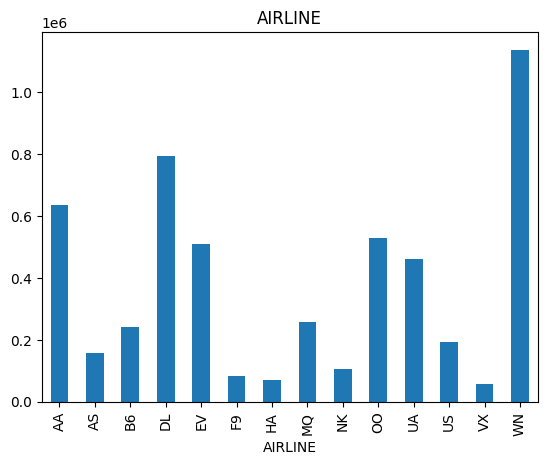

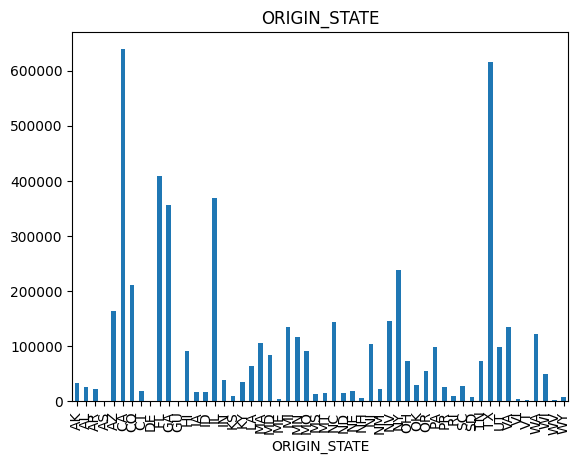

In [6]:
for col in ["AIRLINE", "ORIGIN_STATE"]:
    df_features[col].value_counts().sort_index().plot(kind="bar")
    plt.title(col)
    plt.show()

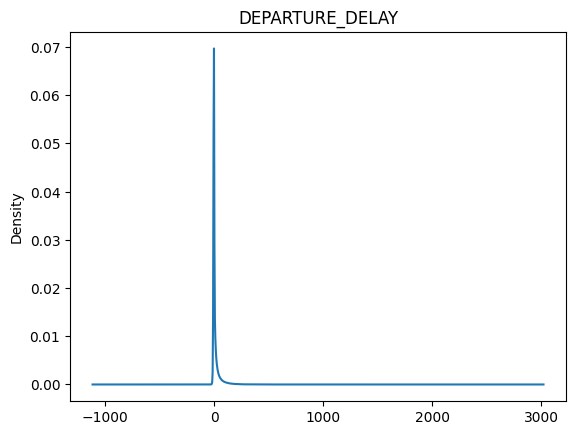

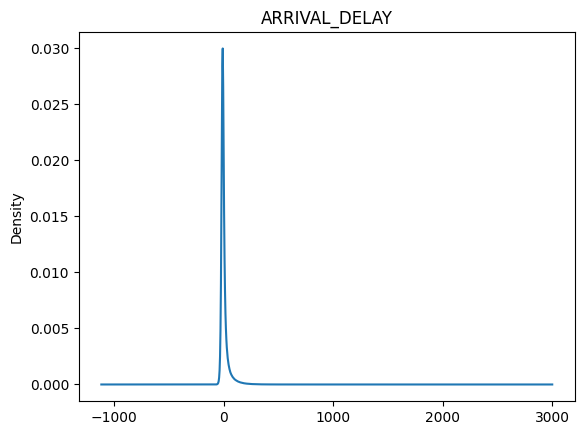

In [7]:
for col in ["DEPARTURE_DELAY", "ARRIVAL_DELAY"]:
    df_features[col].plot(kind="kde")
    plt.title(col)
    plt.show()

The continuous features have outliers, so below I simulate removing them and plotting the distribution. I do not remove the outliers now as this would include removing outliers from the test set. As we are not short on data, I will remove the outliers from the train set later.

In [8]:
# Simulating removing outliers (we later only remove outliers from train set)

nb_entries = len(df_features)
nb_outliers = len(df_features[~df_features["DEPARTURE_DELAY"].between(-15, 180)])

print(f"No. entries: {nb_entries}")
print(f"No. outliers: {nb_outliers}")

df_outliers_removed = df_features[df_features["DEPARTURE_DELAY"].between(-15, 180)]

print(f"Percentage entries to be removed: {nb_outliers / nb_entries * 100:.3f}%")

No. entries: 5231130
No. outliers: 63363
Percentage entries to be removed: 1.211%


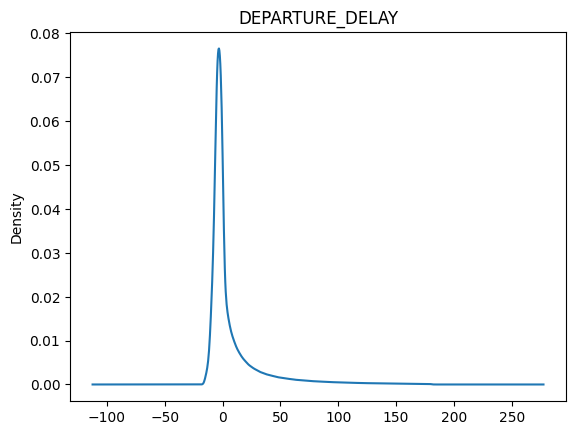

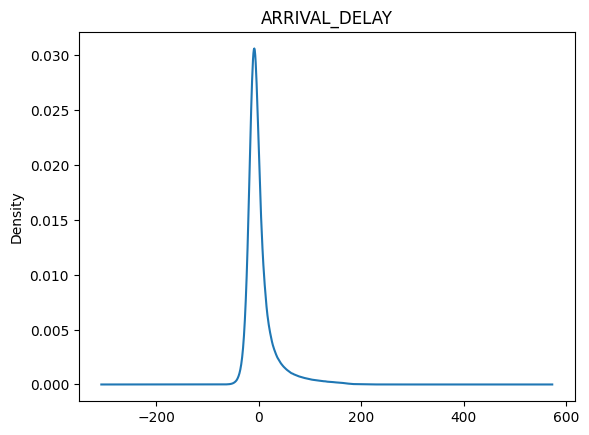

In [9]:
for col in ["DEPARTURE_DELAY", "ARRIVAL_DELAY"]:
    df_outliers_removed[col].plot(kind="kde")
    plt.title(col)
    plt.show()

### Feature Transformation

The features have slightly skewed distributions which may affect model performance. Since the features contain negative values, I use the Yeo-Johnson transformation as it allows for zero and negative values. I also one-hot encode the categorical variables.

In [10]:
X, y = df_features.iloc[:, :-1], df_features.iloc[:, -1]

# One-hot encoding
columns_to_encode = ["AIRLINE", "ORIGIN_STATE"]
X = pd.get_dummies(X, columns=columns_to_encode, drop_first=True, dtype=int)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=79
)

# Removing outliers
mask = X_train["DEPARTURE_DELAY"].between(-15, 180)

X_train, y_train = X_train[mask], y_train[mask]

In [11]:
def clip_outliers(col, a=0.05):
    lower_bound = col.quantile(a / 2)
    upper_bound = col.quantile(1 - a / 2)

    return col.clip(lower_bound, upper_bound)


def transform_dataset(df, cols_to_transform, lmbdas=None):
    # Training set
    if lmbdas is None:
        lmbdas = []
        for col in cols_to_transform:
            # df[col] = clip_outliers(df[col], a=0.01)
            df[col], lmbda = yeojohnson(df[col])
            lmbdas.append(lmbda)

        return df, lmbdas

    # Test set
    else:
        for col, lmbda in zip(cols_to_transform, lmbdas):
            df[col] = yeojohnson(df[col], lmbda)

        return df


cols_to_transform = ["DEPARTURE_DELAY"]

X_train, lmbdas = transform_dataset(X_train, cols_to_transform)
X_test = transform_dataset(X_test, cols_to_transform, lmbdas)

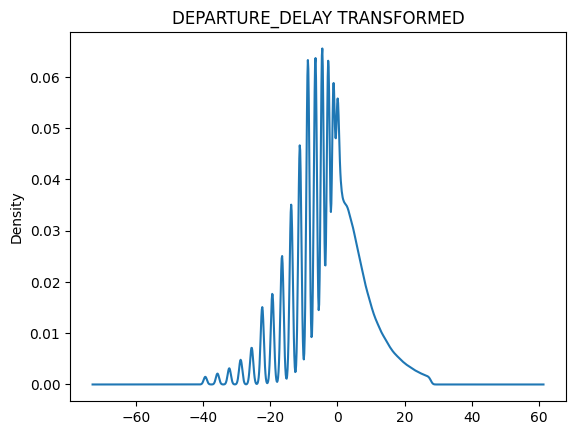

In [12]:
for col in cols_to_transform:
    X_train[col].plot(kind="kde")
    plt.title(f"{col} TRANSFORMED")
    plt.show()

The transformation has resulted in a more symmetric distribution. The zigzag artifact is due to the bandwidth of the plot.

### Model Training

For a basic first model, a linear regression is perfect. We predict a continuous value using a number of features. I use `statsmodels` instead of `scikit-learn` for the linear model as I will be able to analyse the significance of the coefficients easily, which is helpful in analysing the impact of airports and airlines in the arrival delay.

In [13]:
model = sm.OLS(y_train, X_train).fit()

### Model Evaluation

In [14]:
y_pred = model.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

MAE: 16.222


I use the mean absolute error (MAE) as it has an easily interpreted value. On average, our model is off by around 16 minutes, which is not bad for such a simple model using only a fraction of the features.

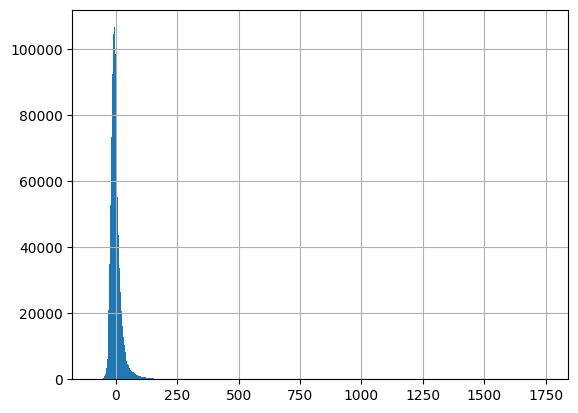

In [15]:
diffs = y_test - y_pred

diffs.hist(bins=500)
plt.show()

I plot the distribution of the errors, as they should be normally distributed. Due to some major outliers, the distribution is skewed. It is to be expected that an exceptional event causes a massive unforseen arrival delay.

15.724656629682123

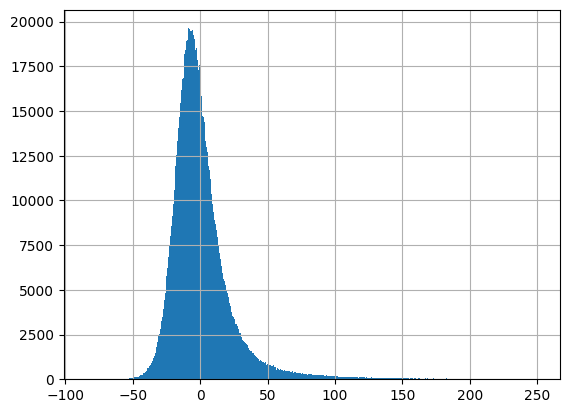

In [16]:
diffs[diffs < 250].hist(bins=500)

diffs[diffs < 250].abs().mean()

Removing the cases where there is a massive delay, we can take a closer look at the distribution of errors.

### Influence of Different Airlines and Airports

In [17]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 6.140e+04
Date:                Mon, 09 Oct 2023   Prob (F-statistic):               0.00
Time:                        23:14:42   Log-Likelihood:            -1.8359e+07
No. Observations:             4134149   AIC:                         3.672e+07
Df Residuals:                 4134081   BIC:                         3.672e+07
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              11.8100      0.149     

The important information here are the R-squared value and the p-values of the coefficients.

The R-squared value of 0.499 means that our model has been able to explain a decent chunk of the variance in the data, but not all of it. This is to be expected as it is a simple model.

Looking at the coefficients and their R-values, we see that most of them are significant. The coefficient values represent the difference in arrival delay with respect to the first option in the category.

The coefficients for the biggest airlines, such as United and Delta, are negative. This suggests that the big airlines are less frequently delayed. Budget airlines, such as Spirit (`AIRLINE_NK`) have larger positive values, showing that they are more frequently late.

## Graph Structure Model

In this part, I will create a linear model using a centrality metric calculated from the graph of flights.

I will use PageRank as the centrality metric. An airport with a larger PageRank value can be seen as a flight hub. One possible hypothesis is that more important airports (with a higher PageRank value) are busier which causes more delays.

In [18]:
# Building a directed graph of flights (allow multiple flights per route)

G = nx.MultiDiGraph()

airports = df_airports.index

for _, row in df_flights.iterrows():
    dep_airport = row["ORIGIN_AIRPORT"]
    arr_airport = row["DESTINATION_AIRPORT"]

    if dep_airport in airports and arr_airport in airports:
        G.add_edge(dep_airport, arr_airport)

# Find important airports (important airport -> busy -> more delays)
pagerank_scores = nx.pagerank(G, alpha=0.85)

In [19]:
df_features = df_flights[df_flights["ORIGIN_AIRPORT"].str.isalpha().astype(bool)]

df_features["AIRPORT_CENTRALITY"] = df_features["ORIGIN_AIRPORT"].map(pagerank_scores)

cols_to_keep = [
    "AIRLINE",
    "ORIGIN_STATE",
    "DEPARTURE_DELAY",
    "AIRPORT_CENTRALITY",
    "ARRIVAL_DELAY",
]

df_features = df_features[cols_to_keep]

df_features[["AIRLINE", "ORIGIN_STATE"]] = df_features[
    ["AIRLINE", "ORIGIN_STATE"]
].astype("category")

df_features = df_features.dropna()

df_features

/var/folders/n0/trk6br690sqb9zn9rsrhqmvm0000gn/T/ipykernel_29689/1678592466.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["AIRPORT_CENTRALITY"] = df_features["ORIGIN_AIRPORT"].map(pagerank_scores)


,AIRLINE,ORIGIN_STATE,DEPARTURE_DELAY,AIRPORT_CENTRALITY,ARRIVAL_DELAY
0,AS,AK,-11.000,0.008,-22.000
1,AA,CA,-8.000,0.029,-9.000
2,US,CA,-2.000,0.024,5.000
3,AA,CA,-5.000,0.029,-9.000
4,AS,WA,-1.000,0.020,-21.000
...,...,...,...,...,...
5819074,B6,CA,-4.000,0.029,-26.000
5819075,B6,NY,-4.000,0.015,-16.000
5819076,B6,NY,-9.000,0.015,-8.000
5819077,B6,FL,-6.000,0.017,-10.000


In [20]:
X, y = df_features.iloc[:, :-1], df_features.iloc[:, -1]

# One-hot encoding
columns_to_encode = ["AIRLINE", "ORIGIN_STATE"]
X = pd.get_dummies(X, columns=columns_to_encode, drop_first=True, dtype=int)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=79
)

# Removing outliers
mask = X_train["DEPARTURE_DELAY"].between(-15, 180)

X_train, y_train = X_train[mask], y_train[mask]

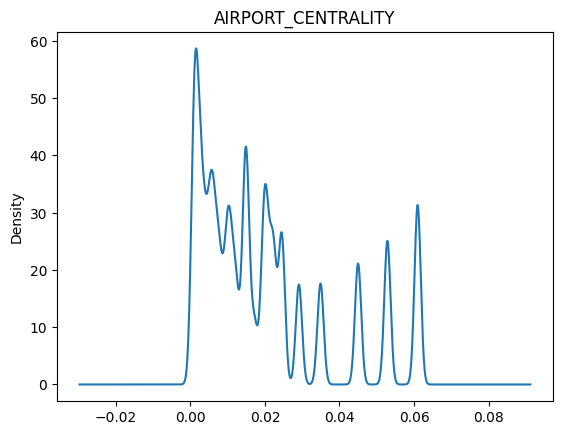

In [21]:
X_train["AIRPORT_CENTRALITY"].plot(kind="kde")
plt.title("AIRPORT_CENTRALITY")
plt.show()

I will apply the same transform as before.

In [22]:
cols_to_transform = ["DEPARTURE_DELAY", "AIRPORT_CENTRALITY"]

X_train, lmbdas = transform_dataset(X_train, cols_to_transform)
X_test = transform_dataset(X_test, cols_to_transform, lmbdas)

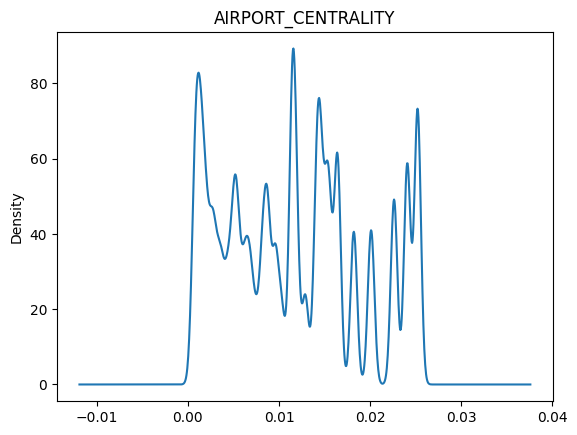

In [23]:
X_train["AIRPORT_CENTRALITY"].plot(kind="kde")
plt.title("AIRPORT_CENTRALITY")
plt.show()

### Model Training

I stick with the same linear model. Another option to try would be to add regularisation (i.e. Ridge or LASSO regression), though this would require scaling the continuous features appropriately as `AIRPORT_CENTRALITY` is distributed orders of magnitude below `ARRIVAL_DELAY`.

In [24]:
model = sm.OLS(y_train, X_train).fit()

### Model Evaluation

In [25]:
y_pred = model.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

MAE: 16.184


There is a slight improvement over the previous model.

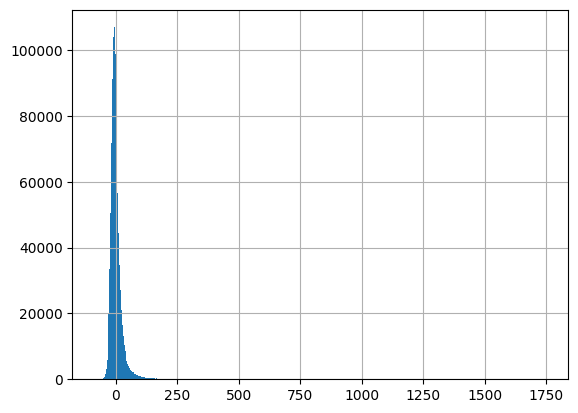

In [26]:
diffs = y_test - y_pred

diffs.hist(bins=500)
plt.show()

15.691275994786361

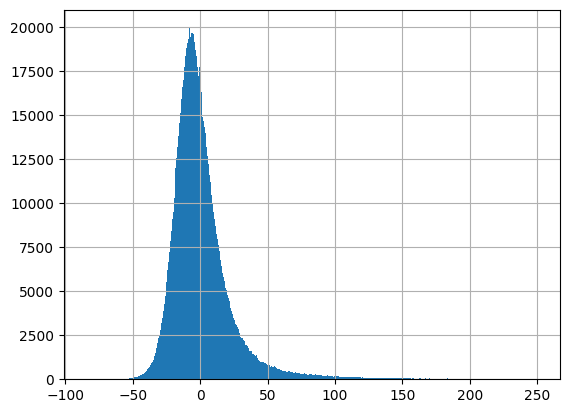

In [27]:
diffs[diffs < 250].hist(bins=500)

diffs[diffs < 250].abs().mean()

### Influence of Different Airlines and Airports

In [28]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                 6.107e+04
Date:                Mon, 09 Oct 2023   Prob (F-statistic):               0.00
Time:                        23:28:04   Log-Likelihood:            -1.8349e+07
No. Observations:             4134149   AIC:                         3.670e+07
Df Residuals:                 4134080   BIC:                         3.670e+07
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 13.9103      0

The negative coefficient for airport centrality indicates that more important airports have fewer delays, indicating that their operation are smoother.

We could have constructed the graph with other features, such as the distance, and used them as other indicators to predict delays. We could also have used methods to find community structures and see if the communities are good predictors of arrival delay.